In [1]:
import tensorflow as tf

# GPU 메모리 동적 할당 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU 메모리 동적 할당 활성화 완료")
    except RuntimeError as e:
        print(e)

GPU 메모리 동적 할당 활성화 완료


In [2]:
# 1. 데이터 로딩 및 전처리
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("cover_data.csv")
X = df.drop(columns=['class'])
y = df['class'] - 1  # 0부터 시작

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [3]:
# 2. 모델 빌더 함수 정의
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

def build_model(optimizer='adam', learning_rate=0.001, dropout_rate=0.3):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(7, activation='softmax'))

    opt = optimizers.Adam(learning_rate=learning_rate) if optimizer == 'adam' else optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Epoch 1/20


/opt/homebrew/Caskroom/mambaforge/base/envs/tf_metal/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-06 01:14:12.899357: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-06 01:14:12.899397: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-06 01:14:12.899407: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1743869652.900048 13684750 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743869652.900294 13684750 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/tas

12710/12710 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.6589 - loss: 0.8783 - val_accuracy: 0.6973 - val_loss: 0.6949
Epoch 2/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.6711 - loss: 0.7859 - val_accuracy: 0.6990 - val_loss: 0.7196
Epoch 3/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.6484 - loss: 0.9046 - val_accuracy: 0.6554 - val_loss: 0.8616
Epoch 4/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.6294 - loss: 1.0528 - val_accuracy: 0.6813 - val_loss: 0.9626


2724/2724 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7000 - loss: 0.6979
Baseline Test Accuracy: 0.7007
2724/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 671us/step
              precision    recall  f1-score   support

           0       0.72      0.63      0.67     31659
           1       0.72      0.83      0.77     42664
           2       0.68      0.53      0.60      5297
           3       0.40      0.53      0.45       394
           4       0.00      0.00      0.00      1493
           5       0.34      0.47      0.40      2591
           6       0.77      0.49      0.60      3054

    accuracy                           0.70     87152
   macro avg       0.52      0.50      0.50     87152
weighted avg       0.69      0.70      0.69     87152



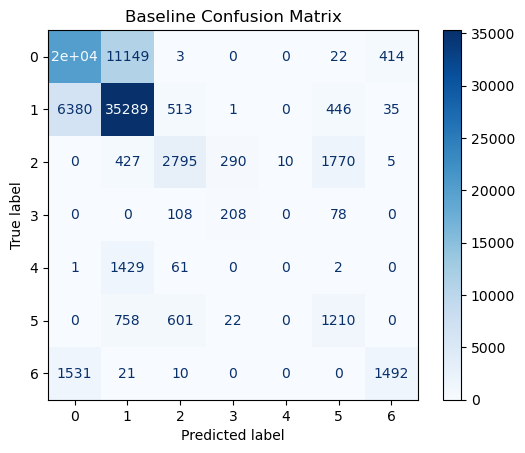

In [4]:
# 3. 베이스라인 모델 훈련 및 평가
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

baseline_model = build_model()
history = baseline_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32,
                             validation_data=(X_val_scaled, y_val), callbacks=[early_stop])

baseline_model.save("cover_classifier_model.h5")
model_loaded = models.load_model("cover_classifier_model.h5")

loss, acc = model_loaded.evaluate(X_test_scaled, y_test)
print(f"Baseline Test Accuracy: {acc:.4f}")

y_pred = model_loaded.predict(X_test_scaled).argmax(axis=1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Baseline Confusion Matrix")
plt.show()

In [9]:
!pip uninstall -y scikit-learn

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1


In [20]:
!pip install scikit-learn==1.5.2

  Using cached scikit_learn-1.5.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-macosx_12_0_arm64.whl (11.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


Trial 10 Complete [00h 05m 09s]
val_accuracy: 0.6639893651008606

Best val_accuracy So Far: 0.7199375629425049
Total elapsed time: 01h 15m 38s

✅ Best hyperparameters:
optimizer: sgd
learning_rate: 0.001615
dropout_rate: 0.2
Epoch 1/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.5620 - loss: 1.1866 - val_accuracy: 0.7110 - val_loss: 0.7029
Epoch 2/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.6796 - loss: 0.7669 - val_accuracy: 0.7126 - val_loss: 0.6841
Epoch 3/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.6877 - loss: 0.7407 - val_accuracy: 0.7171 - val_loss: 0.6753
Epoch 4/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.6943 - loss: 0.7220 - val_accuracy: 0.7169 - val_loss: 0.6694
Epoch 5/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.6971 - loss: 0.7102 - val_accuracy: 0.7155 - val_loss: 0.6647
Epoch 6/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.6974 - loss: 0.7084 - val_accuracy: 0.7

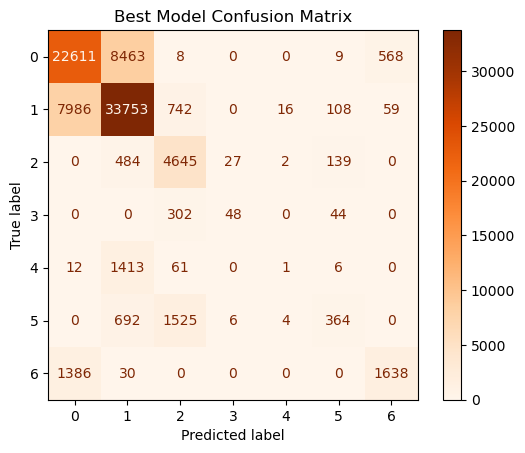

Results summary
Results in my_tuner_dir/cover_tuning
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
optimizer: sgd
learning_rate: 0.001614959126027819
dropout_rate: 0.2
Score: 0.7199375629425049

Trial 06 summary
Hyperparameters:
optimizer: sgd
learning_rate: 0.0006673277125154032
dropout_rate: 0.4
Score: 0.7185950875282288

Trial 02 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.000489857718886714
dropout_rate: 0.4
Score: 0.7164953351020813

Trial 07 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0004614837571285665
dropout_rate: 0.2
Score: 0.7150954604148865

Trial 05 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0003681208037616583
dropout_rate: 0.2
Score: 0.7044014930725098


In [5]:
# 4. 하이퍼파라미터 튜닝 (Keras Tuner 기반)
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

# 1. 빌더 함수 정의 (Keras Tuner에서 사용)
def model_builder(hp):
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    dropout_rate = hp.Choice('dropout_rate', [0.2, 0.4])

    return build_model(optimizer=optimizer, learning_rate=learning_rate, dropout_rate=dropout_rate)

# 2. Keras Tuner 설정
stop_early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='my_tuner_dir',
    project_name='cover_tuning'
)

# 3. 튜닝 시작
tuner.search(X_train_scaled, y_train,
             validation_data=(X_val_scaled, y_val),
             epochs=20,
             batch_size=32,
             callbacks=[stop_early],
             verbose=1)

# 4. 최적 결과 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n✅ Best hyperparameters:")
print(f"optimizer: {best_hps.get('optimizer')}")
print(f"learning_rate: {best_hps.get('learning_rate'):.6f}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")

# 5. 최적 하이퍼파라미터로 모델 재학습
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train_scaled, y_train,
               validation_data=(X_val_scaled, y_val),
               epochs=20,
               batch_size=32,
               callbacks=[stop_early],
               verbose=1)

# 6. 테스트 평가
y_pred_best = best_model.predict(X_test_scaled).argmax(axis=1)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm_best).plot(cmap="Oranges")
plt.title("Best Model Confusion Matrix")
plt.show()

# 7. 튜너 결과 요약 시각화 (trial accuracy)
results = tuner.results_summary(num_trials=5)

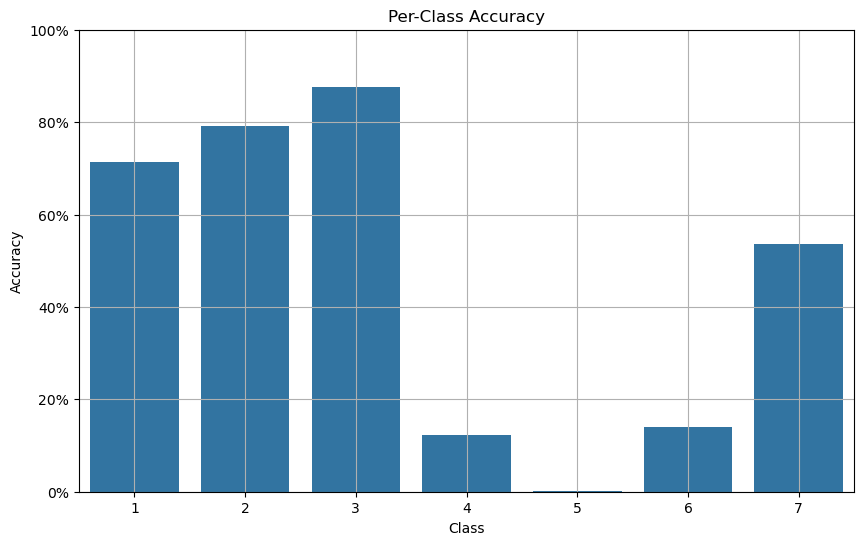

Epoch 1/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.7048 - loss: 0.6821 - val_accuracy: 0.7190 - val_loss: 0.6512
Epoch 2/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.7035 - loss: 0.6812 - val_accuracy: 0.7181 - val_loss: 0.6503
Epoch 3/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.7033 - loss: 0.6821 - val_accuracy: 0.7209 - val_loss: 0.6507
Epoch 4/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.7051 - loss: 0.6802 - val_accuracy: 0.7178 - val_loss: 0.6513
Epoch 5/20
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.7035 - loss: 0.6832 - val_accuracy: 0.7209 - val_loss: 0.6517


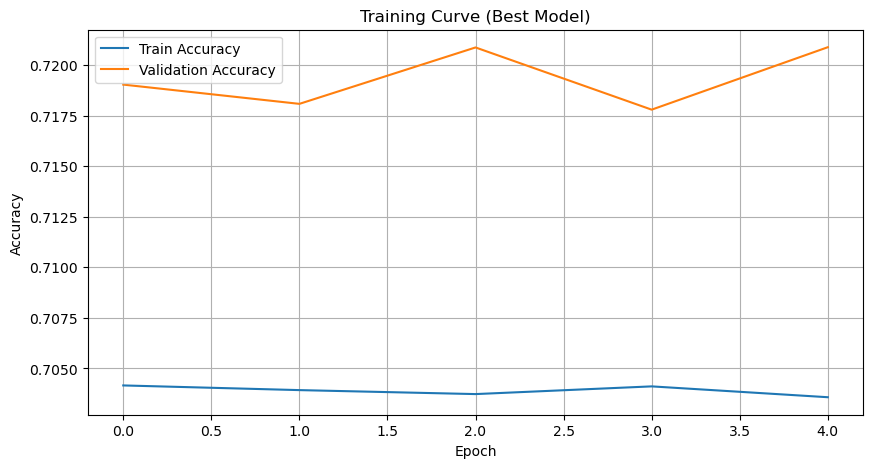

In [6]:
# 5. 성능 시각화
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# confusion matrix 기반 클래스별 정확도 시각화
class_accuracies = cm_best.diagonal() / cm_best.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, 8), y=class_accuracies)
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.show()

# 학습 곡선 시각화를 위해 history 객체 필요
history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

# 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training Curve (Best Model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# 6. 잘못 분류된 샘플 예시 출력
import numpy as np

# 예측 결과와 실제 라벨 비교
y_pred_best = best_model.predict(X_test_scaled).argmax(axis=1)

# 잘못 분류된 인덱스 추출
incorrect_indices = np.where(y_pred_best != y_test)[0]

# 무작위로 5개 샘플 선택
sample_indices = np.random.choice(incorrect_indices, size=5, replace=False)

# 결과 출력
print("\n잘못 분류된 샘플 예시:")
for idx in sample_indices:
    true_label = y_test[idx] if isinstance(y_test, np.ndarray) else y_test.iloc[idx]
    print(f"Index: {idx}, True Label: {true_label}, Predicted: {y_pred_best[idx]}")

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 690us/step

잘못 분류된 샘플 예시:
Index: 40500, True Label: 6, Predicted: 0
Index: 14617, True Label: 1, Predicted: 0
Index: 58282, True Label: 0, Predicted: 1
Index: 11860, True Label: 0, Predicted: 1
Index: 73515, True Label: 1, Predicted: 0


Epoch 1/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.5550 - loss: 1.2253 - val_accuracy: 0.7029 - val_loss: 0.7122
Epoch 2/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.6730 - loss: 0.7743 - val_accuracy: 0.7100 - val_loss: 0.6897
Epoch 3/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.6853 - loss: 0.7410 - val_accuracy: 0.7138 - val_loss: 0.6776
Epoch 4/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.6915 - loss: 0.7231 - val_accuracy: 0.7151 - val_loss: 0.6706
Epoch 5/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.6952 - loss: 0.7138 - val_accuracy: 0.7163 - val_loss: 0.6654
Epoch 6/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.6964 - loss: 0.7068 - val_accuracy: 0.7173 - val_loss: 0.6619
Epoch 7/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.6987 - loss: 0.7020 - val_accuracy: 0.7188 - val_loss: 0.6597
Epoch 8/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 

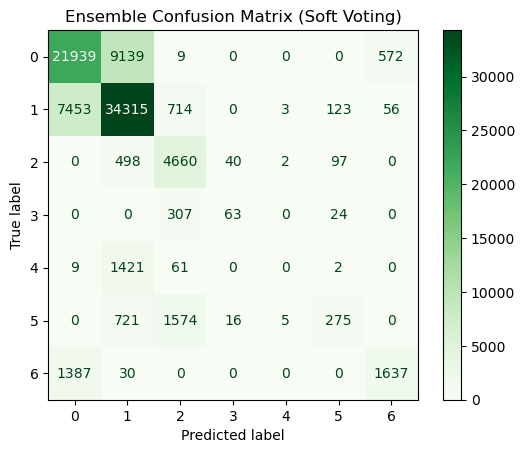

In [9]:
# 7. 소프트 보팅 앙상블
ensemble_models = []
from tensorflow.keras.models import clone_model

# 최적 하이퍼파라미터로 여러 모델 학습
for seed in [1, 2, 3]:
    tf.keras.utils.set_random_seed(seed)
    model = build_model(
        optimizer=best_hps.get('optimizer'),
        learning_rate=best_hps.get('learning_rate'),
        dropout_rate=best_hps.get('dropout_rate')
    )
    model.fit(X_train_scaled, y_train, epochs=10, batch_size=32,
              validation_data=(X_val_scaled, y_val), verbose=1)
    ensemble_models.append(model)

# 앙상블 예측 수행
y_probs_ensemble = np.mean([m.predict(X_test_scaled) for m in ensemble_models], axis=0)
y_pred_ensemble = y_probs_ensemble.argmax(axis=1)

# 결과 출력
print("Ensemble (Soft Voting) Results:")
print(classification_report(y_test, y_pred_ensemble))

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
ConfusionMatrixDisplay(cm_ensemble).plot(cmap="Greens")
plt.title("Ensemble Confusion Matrix (Soft Voting)")
plt.show()

In [11]:
# 8. Heterogeneous Ensemble (Soft vs Hard Voting)
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Keras 모델을 sklearn classifier처럼 감싸는 wrapper
class KerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, optimizer, learning_rate, dropout_rate, epochs=10, batch_size=32):
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        self.model = build_model(
            optimizer=self.optimizer,
            learning_rate=self.learning_rate,
            dropout_rate=self.dropout_rate
        )
        self.model.fit(X, y,
                       epochs=self.epochs,
                       batch_size=self.batch_size,
                       verbose=1)
        return self

    def predict(self, X):
        return self.model.predict(X).argmax(axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)

# 최적 하이퍼파라미터 사용
keras_model = KerasWrapper(
    optimizer=best_hps.get('optimizer'),
    learning_rate=best_hps.get('learning_rate'),
    dropout_rate=best_hps.get('dropout_rate'),
    epochs=10,
    batch_size=32
)

# 다른 모델들과 함께 앙상블 구성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
log_model = LogisticRegression(max_iter=200)

voting_soft = VotingClassifier(estimators=[
    ('keras', keras_model),
    ('rf', rf_model),
    ('logreg', log_model)
], voting='soft')

voting_hard = VotingClassifier(estimators=[
    ('keras', keras_model),
    ('rf', rf_model),
    ('logreg', log_model)
], voting='hard')

# 학습 및 예측
tf.keras.utils.set_random_seed(42)  # keras reproducibility
tf.get_logger().setLevel('ERROR')  # suppress keras warnings
voting_soft.fit(X_train_scaled, y_train)
voting_hard.fit(X_train_scaled, y_train)

y_pred_soft = voting_soft.predict(X_test_scaled)
y_pred_hard = voting_hard.predict(X_test_scaled)

# 결과 출력
print("Soft Voting Results:")
print(classification_report(y_test, y_pred_soft))

print("\nHard Voting Results:")
print(classification_report(y_test, y_pred_hard))

Epoch 1/10


/opt/homebrew/Caskroom/mambaforge/base/envs/tf_metal/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12710/12710 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.5596 - loss: 1.1971
Epoch 2/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.6787 - loss: 0.7656
Epoch 3/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.6892 - loss: 0.7351
Epoch 4/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.6958 - loss: 0.7180
Epoch 5/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.6980 - loss: 0.7086
Epoch 6/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.7000 - loss: 0.7034
Epoch 7/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.7021 - loss: 0.6977
Epoch 8/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.7023 - loss: 0.6932
Epoch 9/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.7023 - loss: 0.6933
Epoch 10/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.7033 - loss: 0.6882
Epoch 1/10


/opt/homebrew/Caskroom/mambaforge/base/envs/tf_metal/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/mambaforge/base/envs/tf_metal/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12710/12710 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.5423 - loss: 1.2292
Epoch 2/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.6776 - loss: 0.7675
Epoch 3/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.6882 - loss: 0.7365
Epoch 4/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.6934 - loss: 0.7204
Epoch 5/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.6955 - loss: 0.7121
Epoch 6/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.6973 - loss: 0.7060
Epoch 7/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.6996 - loss: 0.7013
Epoch 8/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.7001 - loss: 0.6975
Epoch 9/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.7019 - loss: 0.6937
Epoch 10/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.7017 - loss: 0.6919
   9/2724 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step  

/opt/homebrew/Caskroom/mambaforge/base/envs/tf_metal/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2724/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 739us/step
2724/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 741us/step
Soft Voting Results:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     31659
           1       0.84      0.91      0.87     42664
           2       0.79      0.92      0.85      5297
           3       0.84      0.53      0.65       394
           4       0.96      0.11      0.20      1493
           5       0.87      0.50      0.64      2591
           6       0.92      0.71      0.80      3054

    accuracy                           0.84     87152
   macro avg       0.87      0.64      0.69     87152
weighted avg       0.85      0.84      0.84     87152


Hard Voting Results:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72     31659
           1       0.76      0.81      0.79     42664
           2       0.70      0.88      0.78      5297
           3       0.71      0.43      0.53       394